# High resolution satellite imagery and machine learning for building classifer

We develop this notebook to walk you through a convolutional neural net building recognition that transfer learns from ImageNet.  

This tutorial breaks down into three sections:
- train and test dataset generation from Label Maker;
- train a building classifier;
- predict and test the trained model

# Data Downloading with Label Maker


- ### install Label Maker

In [ ]:
# make sure you have python 3.6
# install label maker
!pip install label_maker
# install tippecanoe
!brew install tippecanoe

- ### configure Label Maker

In [5]:
%%file config.json
{
  "country": "united_republic_of_tanzania",
  "bounding_box": [39.105148315429695,-6.627522112236093,39.1933822631836,-6.569970207851596],
  "zoom": 17,
  "classes": [{ "name": "Buildings", "filter": ["has", "building"] }],
  "imagery": "https://a.tiles.mapbox.com/v4/digitalglobe.2lnpeioh/{z}/{x}/{y}.jpg?access_token=",
  "background_ratio": 1,
  "ml_type": "classification"
}

Overwriting config.json


- ### download image tiles
If the downloading is successful, you will see a 'data.npz' downloaded under directory 'tz_buildings'. The directory under 'tz_buildings' will contain:
-- tz_buildings --
             -- classification.geojson
             -- data.npz
             -- labels.npz
             -- tiles
             -- united_republic_of_tanzania-z17.mbtiles
             -- united_republic_of_tanzania.geojson
             -- united_republic_of_tanzania.mbtiles

In [ ]:
!label-maker download --dest tz_buildings --config config.json
!label-maker labels --dest tz_buildings --config config.json
!label-maker preview -n 10 --dest tz_buildings --config config.json
!label-maker images --dest tz_buildings --config config.json
!label-maker package --dest tz_buildings --config config.json

# Train a building classifier with ResNet

We will do a transfer learning from a pretrained model from ImageNet([what is ImageNet?](http://image-net.org/about-overview)), and this pretrained model is ResNet50([What is ResNet](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)). 

## Before training

The building classifier is built on top of TensorFlow ([what is TensorFlow](https://www.tensorflow.org/)) and Keras ([What is Keras](https://keras.io/)). 

TensorFlow is Google’s neural net computational framework; and Keras is a highlevel neural net API that allows you to build different neural net  architecture on frameworks like tensorflow.

**Please install tensorflow and keras before running the model.**

In [ ]:
!pip install tensorflow tensorflow-gpu
!pip install keras

## Train the model 

In [1]:
## import the packages 
import numpy as np
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.layers import Input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
from keras.models import Model
import time

Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 2
epochs = 10

# input image dimensions
img_rows, img_cols = 256, 256
input_shape = (img_rows, img_cols, 3)

In [3]:
# read in training dataset that generated from label maker
npz = np.load('tz_buildings/data.npz')
x_train = npz['x_train']
y_train = npz['y_train']
x_val = npz['x_test']
y_val = npz['y_test']

In [4]:
# save training dataset in float data type so we can do data manipulation later
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')

x_train shape: (580, 256, 256, 3)
x_val shape: (146, 256, 256, 3)
580 train samples
146 test samples


In [5]:
# The image tile has three color channels, and they are RGB;
# We want to compute the mean and std values for each color channels and save it up.
img_mean = np.mean(x_train, axis=(0, 1, 2))
img_std = np.std(x_train, axis=(0, 1, 2))
img_mean, img_std

(array([ 68.95522308,  81.01200104,  65.04355621], dtype=float32),
 array([ 67.17246246,  54.31946182,  49.85364151], dtype=float32))

In [6]:
# The process is to standardize training and calculate how much does each image contribute to the dataset. 

x_train -= img_mean
x_train /= img_std

x_val -= img_mean
x_val /= img_std

In [7]:
x_train.max(), x_val.max(), x_train.min(), x_val.min(), np.median(x_train), np.median(x_val), x_train.shape, x_val.shape

(3.8102825,
 3.8102825,
 -1.4913992,
 -1.4913992,
 -0.055449758,
 -0.040991113,
 (580, 256, 256, 3),
 (146, 256, 256, 3))

In [8]:
# image augmentation
datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=180,
        zoom_range=(1, 1.2))

In [9]:
# weight classes to account for differences in class frequencies
non_background = np.sum(y_train, axis=0)[1]
class_weight = {
    0: 1,
    1: (y_train.shape[0] - non_background) / non_background
}
class_weight

{0: 1, 1: 0.83544303797468356}

In [10]:
#test
(y_val.shape[0] - np.sum(y_val, axis=0)[1]) / np.sum(y_val, axis=0)[1]

0.67816091954022983

In [55]:
image_input = Input(shape=input_shape)
model = ResNet50(weights='imagenet',include_top=False, input_tensor=image_input)
# model.summary()

In [24]:
last_layer = model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)
# add fully-connected & dropout layers
x = Dense(512, activation='relu',name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
x = Dropout(0.5)(x)
# a softmax layer for 4 classes
out = Dense(num_classes, activation='softmax',name='output_layer')(x)

In [32]:
# this is the model we will train
custom_resnet_model = Model(inputs=model.input, outputs=out)
custom_resnet_model.summary()

for layer in custom_resnet_model.layers[:-30]:
    layer.trainable = False

custom_resnet_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.000001),
              metrics=['accuracy'])
# custom_resnet_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 128, 128, 64)  9472        input_2[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 128, 128, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 128, 128, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [33]:
%%time
hist = custom_resnet_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(x_train.shape[0]/ batch_size),
                    epochs=20,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    class_weight=class_weight,
                    workers=4)

Epoch 1/20
18/18 [==============================] - 363s - loss: 0.8224 - acc: 0.4688 - val_loss: 0.7017 - val_acc: 0.5548
Epoch 2/20
18/18 [==============================] - 296s - loss: 0.8327 - acc: 0.4393 - val_loss: 0.6976 - val_acc: 0.5616
Epoch 3/20
18/18 [==============================] - 324s - loss: 0.7621 - acc: 0.5312 - val_loss: 0.6887 - val_acc: 0.5616
Epoch 4/20
18/18 [==============================] - 309s - loss: 0.8513 - acc: 0.4711 - val_loss: 0.6727 - val_acc: 0.5685
Epoch 5/20
18/18 [==============================] - 310s - loss: 0.8287 - acc: 0.5028 - val_loss: 0.6632 - val_acc: 0.5479
Epoch 6/20
18/18 [==============================] - 324s - loss: 0.7612 - acc: 0.5143 - val_loss: 0.6541 - val_acc: 0.5753
Epoch 7/20
18/18 [==============================] - 309s - loss: 0.7743 - acc: 0.5024 - val_loss: 0.6504 - val_acc: 0.5822
Epoch 8/20
18/18 [==============================] - 309s - loss: 0.8240 - acc: 0.4645 - val_loss: 0.6520 - val_acc: 0.5753
Epoch 9/20
18/18

In [35]:
%%time
(loss, accuracy) = custom_resnet_model.evaluate(x_val, y_val, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

146/146 [==============================] - 71s    
[INFO] loss=0.6881, accuracy: 55.4795%
CPU times: user 4min 5s, sys: 9.69 s, total: 4min 15s
Wall time: 1min 11s


# Prediction

Now it's time to test out if the model can correctly predict an image tile cantain building(s) or not.

In [ ]:
%%file config_test.json
{
  "country": "united_republic_of_tanzania",
  "bounding_box": [39.23588991165161,-6.770200423835782,39.257755279541016,-6.7492328507830255],
  "zoom": 17,
  "classes": [{ "name": "Buildings", "filter": ["has", "building"] }],
  "imagery": "https://a.tiles.mapbox.com/v4/digitalglobe.2lnpeioh/{z}/{x}/{y}.jpg?access_token=",
  "background_ratio": 1,
  "ml_type": "classification"
}

We create another configure file takes a bounding box that we know it contains buildings and not building in the satellite imagery.

In [ ]:
!label-maker download --dest tz_test --config config_test.json
!label-maker labels --dest tz_test --config config_test.json
!label-maker images --dest tz_test --config config_test.json

In [ ]:
# install a package that will use to read in image tiles
!pip install pillow

In [47]:
from PIL import Image
#select an image that cantains buildings
img1 = Image.open('tz_test/tiles/79833-68005-17.jpg')
#select another tile that doesn't have any buildings in it
img2 = Image.open('tz_test/tiles/79805-67944-17.jpg')

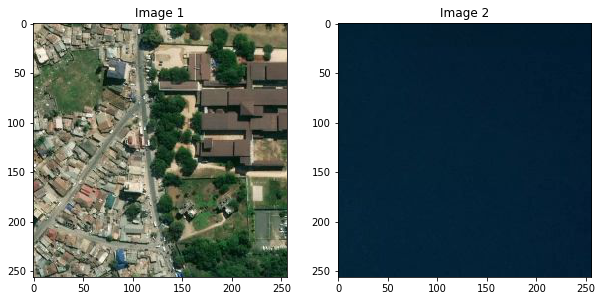

In [48]:
# visualize the two image with matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax =  plt.subplots(1, 2, figsize=(10, 10))

ax[-2].imshow(img1)
ax[-2].set_title('Image 1')

ax[-1].imshow(img2)
ax[-1].set_title('Image 2')

In [49]:
# manipulate the read in images 
# normalize img1
img1 -= img_mean
img1 /= img_std

img2 -= img_mean
img2 /= img_std
img1_arr = img1.reshape(1, img1.shape[0], img1.shape[1], img1.shape[2])
img2_arr = img2.reshape(1, img2.shape[0], img2.shape[1], img2.shape[2])
print('The original image shape is:', img1.shape)
print('The new image shape for the prediction is:', img1_arr.shape)

The original image shape is: (256, 256, 3)
The new image shape for the prediction is: (1, 256, 256, 3)


In [50]:
# the prediction is between 0 and 1. 
pred_img1 = custom_resnet_model.predict(img1_arr)
pred_img2 = custom_resnet_model.predict(img2_arr)

In [51]:
pred_img1, pred_img2

(array([[ 0.41237035,  0.58762968]], dtype=float32),
 array([[ 0.51561505,  0.48438501]], dtype=float32))

In [52]:
pred_img1 = np.squeeze(pred_img1)
pred_img2 = np.squeeze(pred_img2)

In [53]:
# we assume if the propability is high than 0.5, the tile contains building(s), otherwise it's a 'not-building' tile.
if pred_img1[0] < pred_img1[1]:
    print('*'*40)
    print("This is a tile that contains building(s).")
    print('*'*40)
else:
    print('*'*40)
    print("This is a not-building tile!")
    print('*'*40)

****************************************
This is a tile that contains building(s).
****************************************


In [54]:
if pred_img2[0] < pred_img2[1]:
    print('*'*40)
    print("This is a tile that contains building(s).")
    print('*'*40)
else:
    print('*'*40)
    print("This is a not-building tile!")
    print('*'*40)

****************************************
This is a not-building tile!
****************************************


## Next 
For a more complete machine learning case go to chech out https://github.com/developmentseed/ml-hv-grid-pub.